# 工具 (Tools)

当您向智能体（Agent）提出诸如“深圳今天的天气如何？”、“今天下午我有课要上吗？”或“请帮我请一下明天下午的假，因为我生病住院了”等请求时，智能体自身并不能直接提供全面的答复或执行相应的操作。为了有效地响应这些任务，智能体需要利用工具（Tools）来与外部环境进行交互。若将大模型比作智能体的大脑，负责规划任务和发布指令，那么工具就如同智能体的耳目手足，负责获取信息和执行指令，二者缺一不可。

ERNIE Bot Agent 提供了一系列开箱即用的预置工具，也支持开发者自定义工具，以适应不同场景的需求。这些工具主要分为两类：

- 本地工具(LocalTool)：本地工具的工具定义(schema)和工具执行都在本地进行，与 ERNIE Bot Agent 运行在同一进程中。
- 远程工具(RemoteTool)：远程工具的工具定义和工具执行都由某些远程服务（例如星河社区工具中心，或者开发者自己的服务）提供。远程工具的核心在于发送请求和接收响应，ERNIE Bot Agent 对此逻辑进行了高度封装，并与大模型的编排能力相结合，从而实现了智能体的自动化调度。

在开始本教程前，我们需要先获取[飞桨AI Studio星河社区的access_token](https://aistudio.baidu.com/index/accessToken)并且其配置成环境变量，用于对调用大模型和工具中心进行鉴权。

In [1]:
import os
os.environ["EB_AGENT_ACCESS_TOKEN"] = "<access_token>"

## 使用本地工具 (LocalTool)

这一部分将详细介绍如何利用预置的时间工具，并展示本地工具的实际运作方式。

1. **实例化CurrentTimeTool**：首先，我们需要创建CurrentTimeTool的一个实例。
2. **调用工具功能**：创建实例后，我们可以直接调用其`__call__`函数来执行工具的主要功能。通过这种简洁的调用方式，我们能够快速轻松地展示或获取当前时间。
3. **异步执行**：为了确保工具的高效执行，我们已将所有工具统一设置为异步执行模式。因此，在调用`__call__`函数时，需要使用`await`关键字，以确保工具的正确和高效运行。

下面是一个简单的代码示例，展示了如何加载和使用CurrentTimeTool：

In [2]:
from erniebot_agent.tools.current_time_tool import CurrentTimeTool

current_time_tool = CurrentTimeTool()
await current_time_tool()

{'current_time': '2023年12月28日 16时57分37秒'}

下面，我们将展示如何通过将本地工具集成到智能体上，从而扩展和增强其能力。为了实现这一目标，我们构建了一个FunctionAgent，并在创建过程中将CurrentTimeTool工具与之相结合。这一集成使得智能体具备了获取实时时间信息的功能。

一旦智能体被赋予这种能力，我们就可以向其发出诸如“请问现在是几点钟”之类的请求。智能体会利用文心大模型的Function Calling功能，调用CurrentTimeTool来获取当前的时间信息。在获取时间数据后，智能体会利用大模型的语言处理能力对这些信息进行加工和润色，最终以一种自然、流畅的方式将结果反馈给用户。

In [3]:
from erniebot_agent.chat_models import ERNIEBot
from erniebot_agent.agents import FunctionAgent

agent = FunctionAgent(
    llm=ERNIEBot(model="ernie-3.5"),
    tools=[current_time_tool],
)
result = await agent.run("请问现在是几点钟")
print(f"Agent 回复: {result.text}")
print("-----------------")
print("Agent 自动化执行步骤")
for msg in result.chat_history:
    print(msg)

Agent 回复: 根据CurrentTimeTool返回的结果，当前时间是2023年12月28日 16时57分39秒。如果您还有其他问题或需要帮助，请随时告诉我。
-----------------
Agent 自动化执行步骤
<role: 'user', content: '请问现在是几点钟', token_count: 215>
<role: 'assistant', function_call: {'name': 'CurrentTimeTool', 'thoughts': '用户想知道现在几点了，我可以使用CurrentTimeTool来获取当前时间', 'arguments': '{}'}, token_count: 19>
<role: 'function', name: 'CurrentTimeTool', content: '{"current_time": "2023年12月28日 16时57分39秒"}'>
<role: 'assistant', content: '根据CurrentTimeTool返回的结果，当前时间是2023年12月28日 16时57分39秒。如果您还有其他问题或需要帮助，请随时告诉我。', token_count: 42>


## 使用远程工具 (RemoteTool)

在飞桨星河社区，我们集成了众多的远程工具，旨在为开发者提供简单、高效的方式来增强智能体的功能。这些工具可以通过一行代码轻松加载，极大地简化了使用过程。以OCR工具为例，您只需执行一条命令，即可快速调用该工具。更多星河社区预置的远程工具，请访问[星河社区工具中心](https://aistudio.baidu.com/application/center/tool%E3%80%82)。

In [4]:
from erniebot_agent.tools import RemoteToolkit
ocr_tool = RemoteToolkit.from_aistudio("highacc-ocr").get_tools()[0]
ocr_tool

<name: highacc-ocr/v1.8/OCR, server_url: https://tool-highacc-ocr.aistudio-hub.baidu.com/, description: 用于提取并识别图片上的文字及位置信息>

我们下载一个预先准备好的英文路标图片作为示例输入，以便进行后续处理和分析。

In [5]:
!wget https://paddlenlp.bj.bcebos.com/datasets/examples/road_sign.jpeg

--2023-12-28 16:57:44--  https://paddlenlp.bj.bcebos.com/datasets/examples/road_sign.jpeg
Resolving paddlenlp.bj.bcebos.com (paddlenlp.bj.bcebos.com)... 10.70.0.165
Connecting to paddlenlp.bj.bcebos.com (paddlenlp.bj.bcebos.com)|10.70.0.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44056 (43K) [image/jpeg]
Saving to: ‘road_sign.jpeg.1’

100%[======================================>] 44,056      --.-K/s   in 0.01s   

2023-12-28 16:57:44 (3.22 MB/s) - ‘road_sign.jpeg.1’ saved [44056/44056]



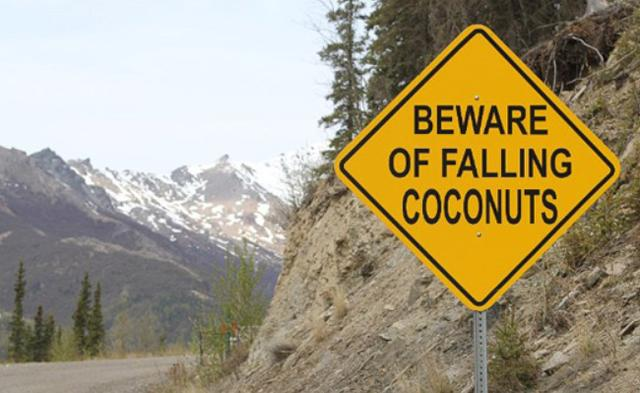

In [6]:
from IPython.display import Image

pil_img = Image(filename='road_sign.jpeg')
display(pil_img)

接下来，我们将利用FileManager将先前下载的图片实例化为File对象。有关File的详细内容和操作，请参阅我们的[File模块文档](https://ernie-bot-agent.readthedocs.io/zh-cn/latest/modules/file/)。完成这一步骤后，我们将File对象的ID作为参数传递给ocr_tool进行处理。通过这种方式，工具能够顺利执行并成功从图片中提取出文字信息。

In [7]:
from erniebot_agent.file import GlobalFileManagerHandler

file_manager = await GlobalFileManagerHandler().get()
local_file = await file_manager.create_file_from_path(file_path='road_sign.jpeg', file_type='local')

await ocr_tool(image=local_file.id)

{'words_result': ['BEWARE', 'OF FALLING', 'COCONUTS'], 'words_result_num': 3}

与本地工具相似，远程工具同样能够被挂载到智能体上，从而扩展其功能和应用范围。通过定义一个FunctionAgent，并在创建时将预先定义好的OCR工具挂载到该智能体上，我们能够轻松地为其增加图像处理和文字识别的能力。

在执行请求“这张图上面的文字说了什么”时，智能体会自动调用挂载的OCR工具，对当前提供的图片进行文字识别。识别结果随后被传递给大模型进行自然语言润色，并最终以自然、流畅的语言形式回复给用户。

In [9]:
agent = FunctionAgent(
    llm=ERNIEBot(model="ernie-3.5"),
    tools=[ocr_tool],
)

result = await agent.run("这张图上面的文字说了什么", files=[local_file])
print(f"Agent 回复: {result.text}")
print("-----------------")
print("Agent 自动化执行步骤")
for msg in result.chat_history:
    print(msg)

Agent 回复: 根据图片中的文字，需要注意“BEWARE”和“FALLING COCONUTS”，也就是说需要小心掉落的椰子。具体而言，这些文字似乎是在警告人们注意从树上掉下来的椰子，因为它们可能会造成伤害或危险。为了确保安全，需要保持警觉并采取适当的预防措施。
-----------------
Agent 自动化执行步骤
<role: 'user', content: '这张图上面的文字说了什么\n<file>file-local-2a66003e-a55f-11ee-a02d-506b4b225bd6</file>', token_count: 428>
<role: 'assistant', function_call: {'name': 'highacc-ocr/v1.8/OCR', 'thoughts': '用户想要知道图片中的文字说了什么；我需要使用OCR工具来提取图片中的文字；根据highacc-ocr/v1.8/OCR工具的定义，全部参数集合为[image, language_type]；其中"required": true的必要参数集合为[image]；结合用户当前问题“这张图上面的文字说了什么”和整个对话历史，用户已经提供了以下参数值{image: \'file-local-2a66003e-a55f-11ee-a02d-506b4b225bd6\'}；其中已经提供对应参数值的"required": true的必要参数集合为[image]；尚未提供对应参数值的"required": true参数列表为[]；由于尚未提供对应参数值的"required": true参数列表为[]，即全部"required": true的必要参数都已经提供，我可以直接调用工具highacc-ocr/v1.8/OCR', 'arguments': '{"image":"file-local-2a66003e-a55f-11ee-a02d-506b4b225bd6"}'}, token_count: 256>
<role: 'function', name: 'highacc-ocr/v1.8/OCR', content: '{"words_result": ["BEWARE", "OF FALLING", "COCONUTS"], "words_result_nu

## 总结

综上所述，我们深入探讨了智能体工具的概念，并详细阐述了本地工具与远程工具之间的主要差异。通过实际示例，我们演示了如何定义和使用这些工具，以及如何将它们与智能体有效地结合，从而增强智能体的功能。

在接下来的内容中，我们将进一步探讨开发者如何根据不同的应用场景自定义本地工具和远程工具，以满足特定需求并实现更高级的功能。